# &#x1F4D1; &nbsp;   Multi-Label Classification of Style Images

## &#x1F310; &nbsp; 0. Code Library, Style, and Links

In [2]:
library(IRdisplay)
library(repr)
library(tensorflow)
library(keras)
library(imager)
library(R6)

In [3]:
keras_backend <- backend()

In [ ]:
display_html("<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #818286; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}
</style>")

In [4]:
image_loading <- function(image_path) {
    image <- keras::image_load(image_path, target_size=c(150,150))
    image <- image_to_array(image) / 255
    image <- array_reshape(image, c(1, dim(image)))
    return(image)
}

In [5]:
image_grayscaled_loading <- function(image_path) {
    image <- keras::image_load(image_path, 
                               target_size=c(150,150),
                               grayscale=T)
    image <- image_to_array(image) / 255
    image <- array_reshape(image, c(1, dim(image)))
    return(image)
}

## &#x1F310; &nbsp; 1. Load and Explore the Data

In [55]:
data <- read.csv("/Users/olgabelitskaya/deep_learning_projects/DL_PP4/data/style.csv")
head(data)

brand_name,brand_label,product_name,product_label,file
Christian Louboutin,0,shoes,0,0_0_001.png
Christian Louboutin,0,shoes,0,0_0_002.png
Christian Louboutin,0,shoes,0,0_0_003.png
Christian Louboutin,0,shoes,0,0_0_004.png
Christian Louboutin,0,shoes,0,0_0_005.png
Christian Louboutin,0,shoes,0,0_0_006.png


[1] 150 150   1   4

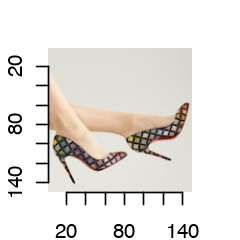

In [56]:
im <- load.image("/Users/olgabelitskaya/deep_learning_projects/DL_PP4/data/0_0_005.png")
options(repr.plot.width=2,repr.plot.height=2)
par(mar=c(2,2,2,2))
dim(im)
plot(im)

In [57]:
image_paths <- list.files("/Users/olgabelitskaya/deep_learning_projects/DL_PP4/data", 
                           recursive = TRUE, full.names = TRUE)
image_paths <- image_paths[1:(length(image_paths)-3)]
tail(image_paths)

[1] "/Users/olgabelitskaya/deep_learning_projects/DL_PP4/data/6_9_002.png"
[2] "/Users/olgabelitskaya/deep_learning_projects/DL_PP4/data/6_9_003.png"
[3] "/Users/olgabelitskaya/deep_learning_projects/DL_PP4/data/6_9_004.png"
[4] "/Users/olgabelitskaya/deep_learning_projects/DL_PP4/data/6_9_005.png"
[5] "/Users/olgabelitskaya/deep_learning_projects/DL_PP4/data/6_9_006.png"
[6] "/Users/olgabelitskaya/deep_learning_projects/DL_PP4/data/6_9_007.png"

In [95]:
c(unique(data['brand_name']))

$brand_name
[1] Christian Louboutin Chanel              Dolce & Gabbana    
[4] Gucci               Christian Dior      Versace            
[7] Yves Saint Laurent 
7 Levels: Chanel Christian Dior Christian Louboutin Dolce & Gabbana ... Yves Saint Laurent

In [59]:
c(unique(data['product_name']))

$product_name
 [1] shoes       lipstick    handbag     nail polish boots       necklace   
 [7] watches     ring        bracelet    earrings   
10 Levels: boots bracelet earrings handbag lipstick nail polish ... watches

## &#x1F310; &nbsp; 2. Implement Preprocess Functions

In [60]:
brands <- as.matrix(data["brand_label"])
products <- as.matrix(data["product_label"])
brand_targets <- keras::to_categorical(brands,7)
product_targets <- keras::to_categorical(products,10)
dim(brands); dim(products); dim(brand_targets); dim(product_targets)

[1] 894   1

[1] 894   1

[1] 894   7

[1] 894  10

In [61]:
image_tensors <- lapply(image_paths, image_loading)
image_tensors <- array_reshape(image_tensors, c(-1,150*150*3))

In [62]:
targets <- cbind(brand_targets,product_targets)

In [63]:
dim(image_tensors); dim(targets)

[1]   894 67500

[1] 894  17

In [64]:
df <- data.frame(image_tensors,brand_targets,product_targets,targets)
df <- df[sample(nrow(df)),]
dim(df)

[1]   894 67534

Dimensions: 150 150 3    Brand:  3    Product:  8

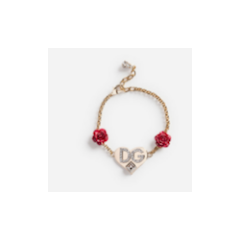

In [80]:
options(repr.plot.width=2,repr.plot.height=2)
par(mar=c(2,2,2,2))
image_example <- array_reshape(as.matrix(df[200,1:67500]),c(150,150,3))
cat("Dimensions:", dim(image_example), "  ", 
    "Brand: ",which(df[200,67501:67507]==1),"  ",
    "Product: ",which(df[200,67508:67517]==1))
plot(as.raster(image_example))

In [83]:
train_indices <- 1:round(0.8 * nrow(df))
valid_indices <- (round(0.8 * nrow(df)) + 1):round(0.9 * nrow(df))
test_indices <- (round(0.9 * nrow(df)) + 1):nrow(df)

In [84]:
x_train1 <- as.matrix(df[train_indices,1:67500])
x_valid1 <- as.matrix(df[valid_indices,1:67500])
x_test1 <- as.matrix(df[test_indices,1:67500])

In [85]:
y_train1 <- as.matrix(df[train_indices,67501:67507])
y_valid1 <- as.matrix(df[valid_indices,67501:67507])
y_test1 <- as.matrix(df[test_indices,67501:67507])

y_train2 <- as.matrix(df[train_indices,67508:67517])
y_valid2 <- as.matrix(df[valid_indices,67508:67517])
y_test2 <- as.matrix(df[test_indices,67508:67517])

y_train3 <- as.matrix(df[train_indices,67518:67534])
y_valid3 <- as.matrix(df[valid_indices,67518:67534])
y_test3 <- as.matrix(df[test_indices,67518:67534])

In [86]:
dim(x_train1); dim(x_valid1); dim(x_test1); dim(y_train3); dim(y_valid3); dim(y_test3)

[1]   715 67500

[1]    90 67500

[1]    89 67500

[1] 715  17

[1] 90 17

[1] 89 17

In [87]:
gray_image_tensors <- lapply(image_paths, image_grayscaled_loading)
gray_image_tensors <- array_reshape(gray_image_tensors, c(-1,150*150))

In [88]:
gray_df <- data.frame(gray_image_tensors,brand_targets,product_targets,targets)
gray_df <- gray_df[sample(nrow(gray_df)),]
dim(gray_df)

[1]   894 22534

Dimensions: 150 150    Brand:  5    Product:  9

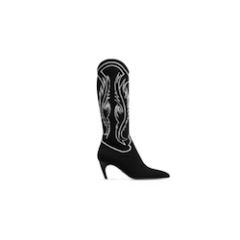

In [89]:
options(repr.plot.width=2,repr.plot.height=2)
par(mar=c(2,2,2,2))
image_example <- array_reshape(as.matrix(gray_df[500,1:22500]),c(150,150))
cat("Dimensions:", dim(image_example), "  ", 
    "Brand: ",which(gray_df[500,22501:22507]==1),"  ",
    "Product: ",which(gray_df[500,22508:22517]==1))
plot(as.raster(image_example))

In [100]:
x_train2 <- as.matrix(gray_df[train_indices,1:22500])
x_valid2 <- as.matrix(gray_df[valid_indices,1:22500])
x_test2 <- as.matrix(gray_df[test_indices,1:22500])

In [101]:
y_train4 <- as.matrix(gray_df[train_indices,22501:22507])
y_valid4 <- as.matrix(gray_df[valid_indices,22501:22507])
y_test4 <- as.matrix(gray_df[test_indices,22501:22507])

y_train5 <- as.matrix(gray_df[train_indices,22508:22517])
y_valid5 <- as.matrix(gray_df[valid_indices,22508:22517])
y_test5 <- as.matrix(gray_df[test_indices,22508:22517])

y_train6 <- as.matrix(gray_df[train_indices,22518:22534])
y_valid6 <- as.matrix(gray_df[valid_indices,22518:22534])
y_test6 <- as.matrix(gray_df[test_indices,22518:22534])

In [102]:
dim(x_train2); dim(x_valid2); dim(x_test2); dim(y_train6); dim(y_valid6); dim(y_test6)

[1]   715 22500

[1]    90 22500

[1]    89 22500

[1] 715  17

[1] 90 17

[1] 89 17

## &#x1F310; &nbsp; 3. One-Label Classification Models